# Introduction

## Defining the problem and assembling a dataset

In this courswork the Malaria dataset from the National Institutes of Health(NIH) will be used to follow the workflow of Deep learning with Python. 
The dataset is availabe for download at:  https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html under the rubric 'Malaria Datasets.' 

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. Even though it is preventable and curable, there were an estimated 241 million cases of malaria worldwide with an estimated  number of maalria deaths at 627 000  in 2020.[1]

Early diagnosis and treatment of malaria reduces disease, prevents deaths and contributes to reducing transmission. This life-threatening disease is caused by Plasmodium parasites that infect the red blood cells (RBCs).

Manual identification and counting of parasitized cells in microscopic thick/thin-film blood examination remains the common, but burdensome method for disease diagnosis. Its diagnostic accuracy is adversely impacted by inter/intra-observer variability, particularly in large-scale screening under resource-constrained settings.[2]

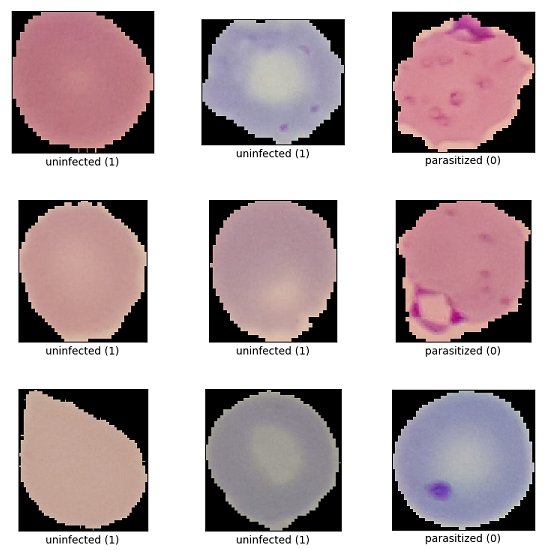

The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.

The objective and challenge is to build and train a convolutional  neural network, which should predict the correct label of a given imagine and therefore aid with diagnosis.[3]


#  Methodology


## Choosing a measure of success

Since this is a binary imagine classification task the metric of success will be the test accuarcy and test loss of the model. A satisfaying result would be to achieve 90% accuracy or higher. The higher the accuary, the more satisfing is the result.
Because missing a parasitized  cell would potentionally result in not treating and helping an infected indivudal and perhaps result in death, if this application was used in the real world.

## Deciding on an evaluation protocol

Because the malaria dataset contains 27,558 cell images, maintainging a hold-out-validation and test set is  viable. With equal instances of parasitized and uninfected cell images, splitting them in a 70/20/10 ratio means there are 19290 images  for training, 5512 images for validation and  2756 images for testing.


# Implementation

## Preparing the data

In [4]:
# importing libraries
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from tensorflow.keras import optimizers

print(tf.__version__)

2.7.0


In [5]:
!pip install split-folders

In [6]:
# importing  helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import splitfolders
import shutil

The cell_imagines.zip was downloaded and extracted to the same directory as this jupyter notebook.

In the cell  below,  the  cell_images folder will  be  divided into train, validation  and test folders.

In [79]:
# Using the splitfolders library to split the image data into subdirectories, this might take a little while
#  source: https://pypi.org/project/split-folders/

#  input directory where the sub directory for train, validation and test data will be placed
input_folder='cell_images/'

# delete data directory, so this code can be run several times without creating more than one data directory
shutil.rmtree('cell_images/data', ignore_errors=True)

# split subfolders from cell_images into train, validaiton and test folders with ratio 70% training 20%validaiton  and 10% testing
splitfolders.ratio(input_folder, output='cell_images/data',
                   seed=42, ratio=(.7, .2, .1),
                   group_prefix=None)

Copying files: 27560 files [03:51, 119.16 files/s]


In [8]:
# paths for training, validation and test data
train_dir = r'./cell_images/data/train'
validation_dir = r'./cell_images/data/val'
test_dir = r'./cell_images/data/test'

In [9]:
# for now the training data will not be augmented, just the usual rescaling will be applied
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [80]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 19290 images belonging to 2 classes.


In [81]:
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 5512 images belonging to 2 classes.


In [12]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 2756 images belonging to 2 classes.


In [13]:
# check if the right amount of images have been found
assert train_generator.n == 19290 
assert validation_generator.n == 5512  
assert test_generator.n == 2756  

In [14]:
# function for plotting 10 images of the training batch
# source:https://www.tensorflow.org/tutorials/images/classification#visualize_training_images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

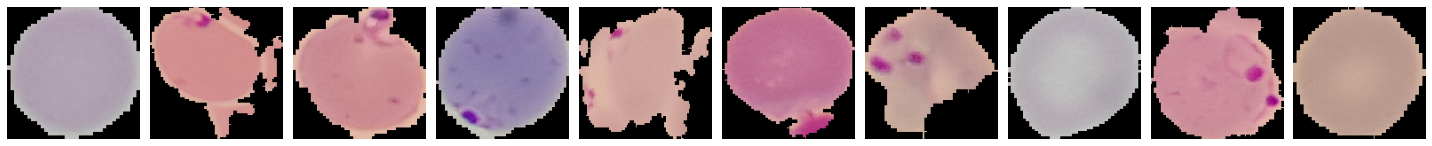

[1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.]


In [15]:
# plotting the images and the printing the corresponding label
imgs, labels = next(train_generator)
plotImages(imgs)
print(labels)

Now the data has been prepared and a validation and a test set have been set aside. With the ImageDataGenerator  the images will be processed into tensors, so the data is ready  to be  fed  into a neural  network.

## Developing a model that does better than a baseline

The first goal is to achieve statistical power, which means to develp a model that does better than a random statistic baseline. In the exmaple of this dataset with 2 classes the baseline to beat would be 50%, because a model, wich would predict the labels at random would have a 50% chance of being correct each time.


3 key choices need to be  made when building a neural network:

1.Last layer acitvation: Here I'll need to go with the 'sigmoid' activation, because this is a binary classification task.
          
2.Loss function: The recommended loss function when facing a   binary classification
task is to use the 'binary_crossentropy' loss function.          
          
3.Optimization: In most cases it is safe to use 'adam' or 'rsmprop'.

##  CNN Model Building

In [16]:
# building and training  first simple and basic model with a Conv2D and a MaxPooling layers
basic_model = Sequential()
basic_model.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
basic_model.add(MaxPool2D(2,2))
basic_model.add(Flatten())
basic_model.add(Dense(1, activation='sigmoid'))

basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history = basic_model.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=10,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/10
965/965 [==============================] - 208s 215ms/step - loss: 0.6036 - accuracy: 0.6853 - val_loss: 0.5366 - val_accuracy: 0.7540
Epoch 2/10
965/965 [==============================] - 117s 121ms/step - loss: 0.4672 - accuracy: 0.8079 - val_loss: 0.4581 - val_accuracy: 0.8006
Epoch 3/10
965/965 [==============================] - 116s 120ms/step - loss: 0.3540 - accuracy: 0.8831 - val_loss: 0.4391 - val_accuracy: 0.8160
Epoch 4/10
965/965 [==============================] - 115s 120ms/step - loss: 0.2846 - accuracy: 0.9100 - val_loss: 0.4338 - val_accuracy: 0.8155
Epoch 5/10
965/965 [==============================] - 116s 120ms/step - loss: 0.2379 - accuracy: 0.9270 - val_loss: 0.5245 - val_accuracy: 0.7594
Epoch 6/10
965/965 [==============================] - 115s 120ms/step - loss: 0.2031 - accuracy: 0.9374 - val_loss: 0.5169 - val_accuracy: 0.8140
Epoch 7/10
965/965 [==============================] - 117s 121ms/step - loss: 0.1737 - accuracy: 0.9509 - val_loss: 0.5048 -

In [17]:
# function  for plotting Training  and validation  accuarcy and loss
# source: DLWP Listing 5.10 Displaying curves of loss and accuracy during training
def plot_result(history):    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

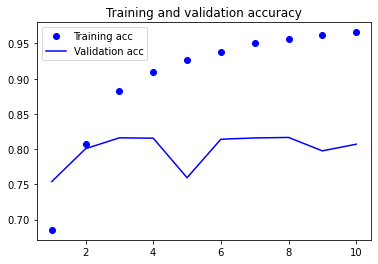

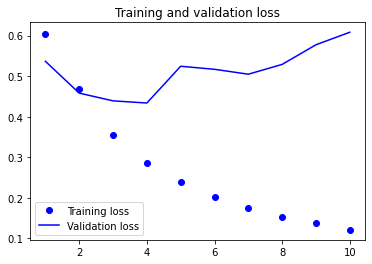

In [18]:
plot_result(history)

Even though a very  simple and basic  CNN has been  used with only one  layer of  Conv2D and maxpooling respectively,
statistical power has been achieved as the baselinemodel has a validation accuarcy of ~79% which beats  the commonsense baseline of 50%.

This also confirms that the outputs can correctly be predicted by given inputs and that the available data is sufficently informative to learn the realtionship between inputs and outputs.

## Identification of overfitting  from loss/validation plots

When looking at the second plot 'Training and validation loss' or at the edited picture below,  we see training and validation loss both go towards 0 at first but then after the 4th epoch the validation loss starts increasing again. That is how overfitting can by identified by  plotting training and validation data. The model is adapting too much to the training data and  gets increasingly worse on the validation set. So the basic_model beat the baseline even though it was overfitting.


## Identification of optimal number of epochs fromo loss/validaiton plots

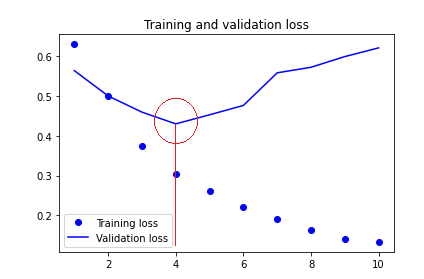


As seen in this edited picture above, the optimal number of epochs is right there, before the model starts overfitting, which was explained in the paragraph above. In the case of this example the optimal  number of epochs would be 4. 
For now, the basic_model will be scaled  up and to achieve higher accuary.


## Scaling up: developing a model that overfits

In this part of the workflow the model now needs to be scaled up and overfitted. This is achieved in 3 steps:

1. Adding more layers

2. Making the layers bigger

3. Train for more epochs

In the code below, I will try different sizes of layers and epochs.

### Step 1: Adding more layers

model_2: 3  Conv2D and MaxPool layers, 2  more each than the basic_model.

In [19]:
# Adding more 2 more sets  of conv2d and maxpooling layers to the  basic model
model_2 = Sequential()
model_2.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_2.add(MaxPool2D(2,2))
model_2.add(Conv2D(32, (3,3), activation='relu'))
model_2.add(MaxPool2D(2,2))
model_2.add(Conv2D(64, (3,3), activation='relu'))
model_2.add(MaxPool2D(2,2))
model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_2 = model_2.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=10,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/10
965/965 [==============================] - 218s 225ms/step - loss: 0.4526 - accuracy: 0.7922 - val_loss: 0.2971 - val_accuracy: 0.8868
Epoch 2/10
965/965 [==============================] - 217s 225ms/step - loss: 0.2119 - accuracy: 0.9272 - val_loss: 0.1711 - val_accuracy: 0.9418
Epoch 3/10
965/965 [==============================] - 218s 226ms/step - loss: 0.1588 - accuracy: 0.9460 - val_loss: 0.1490 - val_accuracy: 0.9521
Epoch 4/10
965/965 [==============================] - 217s 225ms/step - loss: 0.1413 - accuracy: 0.9526 - val_loss: 0.1586 - val_accuracy: 0.9441
Epoch 5/10
965/965 [==============================] - 218s 226ms/step - loss: 0.1255 - accuracy: 0.9573 - val_loss: 0.1450 - val_accuracy: 0.9530
Epoch 6/10
965/965 [==============================] - 219s 227ms/step - loss: 0.1113 - accuracy: 0.9616 - val_loss: 0.1582 - val_accuracy: 0.9485
Epoch 7/10
965/965 [==============================] - 219s 227ms/step - loss: 0.0974 - accuracy: 0.9669 - val_loss: 0.1565 -

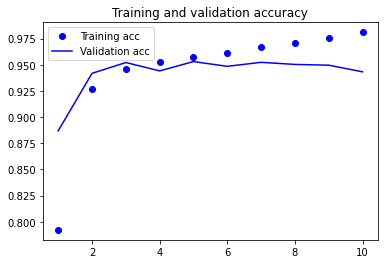

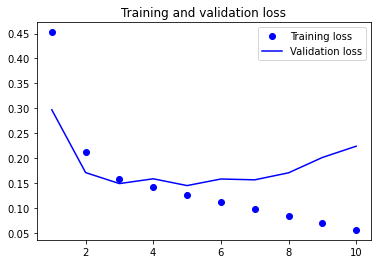

In [20]:
plot_result(history_2)

Validation Accuarcy at around 94-95% was achieved which is a significant improvment from the basic_model. The model is already overfitting aswell as seen by the second  plot.

### Step2: Making the layers bigger

Bigger convolutional layers for model 3.

model_3: Conv2D(32),Conv2D(64) and Conv2D(128) instead of the  Conv2D(16),Conv2D(32) and  Conv2D(64) from the model_2.

In [21]:
# Making the layers biggers
model_3 = Sequential()
model_3.add(Conv2D(32, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_3.add(MaxPool2D(2,2))
model_3.add(Conv2D(64, (3,3), activation='relu'))
model_3.add(MaxPool2D(2,2))
model_3.add(Conv2D(128, (3,3), activation='relu'))
model_3.add(MaxPool2D(2,2))
model_3.add(Flatten())
model_3.add(Dense(1, activation='sigmoid'))

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_3 = model_3.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=10,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/10
965/965 [==============================] - 408s 423ms/step - loss: 0.5134 - accuracy: 0.7510 - val_loss: 0.3598 - val_accuracy: 0.8578
Epoch 2/10
965/965 [==============================] - 405s 420ms/step - loss: 0.2453 - accuracy: 0.9138 - val_loss: 0.1609 - val_accuracy: 0.9474
Epoch 3/10
965/965 [==============================] - 408s 423ms/step - loss: 0.1451 - accuracy: 0.9504 - val_loss: 0.1411 - val_accuracy: 0.9570
Epoch 4/10
965/965 [==============================] - 408s 422ms/step - loss: 0.1278 - accuracy: 0.9558 - val_loss: 0.1484 - val_accuracy: 0.9523
Epoch 5/10
965/965 [==============================] - 408s 423ms/step - loss: 0.1105 - accuracy: 0.9628 - val_loss: 0.1627 - val_accuracy: 0.9517
Epoch 6/10
965/965 [==============================] - 408s 423ms/step - loss: 0.0956 - accuracy: 0.9674 - val_loss: 0.1772 - val_accuracy: 0.9494
Epoch 7/10
965/965 [==============================] - 407s 422ms/step - loss: 0.0815 - accuracy: 0.9734 - val_loss: 0.1917 -

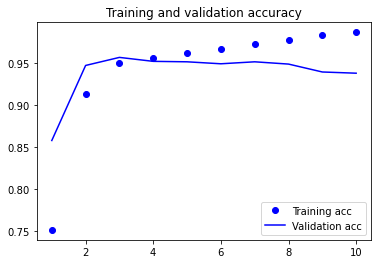

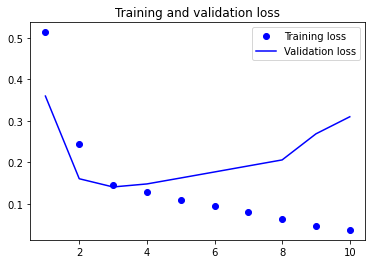

In [22]:
plot_result(history_3)

Making bigger layers did not improve validation accuracy as it stayed the same ~ 95%. And the model_3 is overfitting more than the previous model_2.

### Step 3: trainig for more epochs

model_4 will be the same as model_3, but will be trained for twice as much epochs, which is 20.

In [23]:
# Trainig for more epochs
model_4 = Sequential()
model_4.add(Conv2D(32, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_4.add(MaxPool2D(2,2))
model_4.add(Conv2D(64, (3,3), activation='relu'))
model_4.add(MaxPool2D(2,2))
model_4.add(Conv2D(128, (3,3), activation='relu'))
model_4.add(MaxPool2D(2,2))
model_4.add(Flatten())
model_4.add(Dense(1, activation='sigmoid'))

model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_4 = model_4.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=20,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/20
965/965 [==============================] - 406s 421ms/step - loss: 0.4500 - accuracy: 0.8074 - val_loss: 0.3203 - val_accuracy: 0.9383
Epoch 2/20
965/965 [==============================] - 408s 422ms/step - loss: 0.1849 - accuracy: 0.9398 - val_loss: 0.1615 - val_accuracy: 0.9523
Epoch 3/20
965/965 [==============================] - 408s 423ms/step - loss: 0.1396 - accuracy: 0.9522 - val_loss: 0.1613 - val_accuracy: 0.9407
Epoch 4/20
965/965 [==============================] - 408s 423ms/step - loss: 0.1248 - accuracy: 0.9563 - val_loss: 0.1497 - val_accuracy: 0.9514
Epoch 5/20
965/965 [==============================] - 408s 422ms/step - loss: 0.1128 - accuracy: 0.9623 - val_loss: 0.1682 - val_accuracy: 0.9543
Epoch 6/20
965/965 [==============================] - 411s 426ms/step - loss: 0.0971 - accuracy: 0.9671 - val_loss: 0.1735 - val_accuracy: 0.9536
Epoch 7/20
965/965 [==============================] - 408s 423ms/step - loss: 0.0831 - accuracy: 0.9705 - val_loss: 0.2117 -

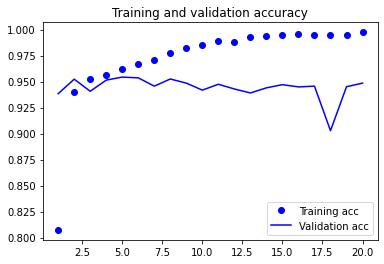

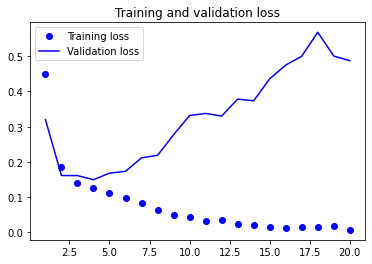

In [24]:
plot_result(history_4)

Because I use the ImageDataGenerator like this:

    x = train_generator,
    steps_per_epoch=len(train_generator)
    
The model trains on the whole training data for each epoch. The result for model_4 was obvious from the beginning: immense overfitting. ALso accuarcy suffered a bit as 95% was not achieved each epoch.

In [25]:
# function for comparing and plotting the loss of 2 models
# source: DSM150-2021-OCT, lecture 4.405 Adding weight regularisation
def plot_loss_comparison(loss_a, label_a, loss_b, label_b):
    
    epochs= range(1,len(loss_a) + 1)
    
    plt.plot(epochs, loss_a,'b+', label = label_a)
    plt.plot(epochs, loss_b, 'bo', label = label_b)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.legend()
    plt.show()

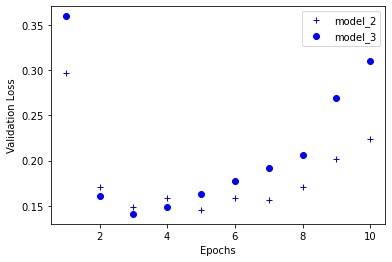

In [26]:
# plotting validation loss of model_3(mo than basic_model) against model_4(bigger layers and more epochs than model_2)
net_a, net_b = 'model_2', 'model_3'
plot_loss_comparison(loss_a = history_2.history['val_loss'],label_a = net_a,
                     loss_b = history_3.history['val_loss'],label_b = net_b)

In all 3 cases of model_2, model_3 and model_4 overfitting has been achieved as the validation loss increased as more epochs were trained on. Validation accuarcy stayed at the same level at around 94% for each model. 


##  Regularizing your model and tuning your hyperparameters

In this step the optimal configuration of the model needs to be found. Several different models need to be built and evaluated to find the best version.

This step requires to: 

1. Add dropout layers.

2. Try different architectures.

3. Add regularization.

4. Try different hyperparameter.



To ensure there are no data leaks from the validation set, I will build models from scratch every time and rebuild a model with the best settings before finally training it on the whole training data and testing it.


Since model 2-4 all had the same validation accaurcy and a part of tuning hyperparameters is to remove layers, I will use the model_2 as a base to tune hyperparameters from and to find the perfect model.

### Add Dropout

In [27]:
# Adding 2 layers of droput to the model with 3 conv2d and maxpooling layers
model_5 = Sequential()
model_5.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_5.add(MaxPool2D(2,2))
model_5.add(Dropout(0.2))
model_5.add(Conv2D(32, (3,3), activation='relu'))
model_5.add(MaxPool2D(2,2))
model_5.add(Dropout(0.3))
model_5.add(Conv2D(64, (3,3), activation='relu'))
model_5.add(MaxPool2D(2,2))
model_5.add(Flatten())
model_5.add(Dense(1, activation='sigmoid'))

model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_5 = model_5.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=10,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/10
965/965 [==============================] - 252s 261ms/step - loss: 0.5399 - accuracy: 0.7363 - val_loss: 0.5630 - val_accuracy: 0.6892
Epoch 2/10
965/965 [==============================] - 251s 261ms/step - loss: 0.2439 - accuracy: 0.9160 - val_loss: 0.1686 - val_accuracy: 0.9476
Epoch 3/10
965/965 [==============================] - 252s 261ms/step - loss: 0.1606 - accuracy: 0.9454 - val_loss: 0.1600 - val_accuracy: 0.9463
Epoch 4/10
965/965 [==============================] - 251s 260ms/step - loss: 0.1433 - accuracy: 0.9504 - val_loss: 0.2228 - val_accuracy: 0.9131
Epoch 5/10
965/965 [==============================] - 252s 261ms/step - loss: 0.1360 - accuracy: 0.9524 - val_loss: 0.1634 - val_accuracy: 0.9523
Epoch 6/10
965/965 [==============================] - 263s 273ms/step - loss: 0.1306 - accuracy: 0.9551 - val_loss: 0.1537 - val_accuracy: 0.9496
Epoch 7/10
965/965 [==============================] - 250s 259ms/step - loss: 0.1180 - accuracy: 0.9591 - val_loss: 0.1682 -

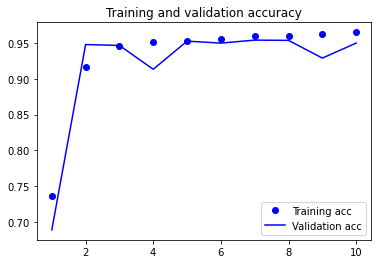

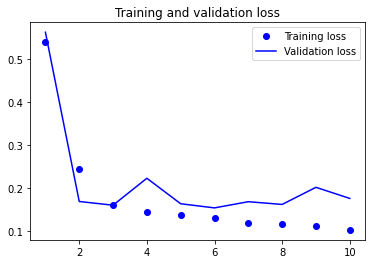

In [28]:
plot_result(history_5)

Adding dropout has fixed some of the overfitting but not all and also did not help with increasing the accuracy.

### Trying a different  learnings rate for the optimizer

In [29]:
# different  learning  rate,default was 0.01 before, new = learning_rate=0.02, otherwise model is the same as model_5
model_6 = Sequential()
model_6.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_6.add(MaxPool2D(2,2))
model_6.add(Dropout(0.2))
model_6.add(Conv2D(32, (3,3), activation='relu'))
model_6.add(MaxPool2D(2,2))
model_6.add(Dropout(0.3))
model_6.add(Conv2D(64, (3,3), activation='relu'))
model_6.add(MaxPool2D(2,2))
model_6.add(Flatten())
model_6.add(Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.02)
model_6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['accuracy'])

history_6 = model_6.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=10,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/10
965/965 [==============================] - 247s 255ms/step - loss: 0.7285 - accuracy: 0.4977 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
965/965 [==============================] - 246s 255ms/step - loss: 0.6937 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
965/965 [==============================] - 247s 256ms/step - loss: 0.6936 - accuracy: 0.4990 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 4/10
965/965 [==============================] - 246s 255ms/step - loss: 0.6937 - accuracy: 0.4965 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 5/10
965/965 [==============================] - 246s 255ms/step - loss: 0.6939 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
965/965 [==============================] - 248s 257ms/step - loss: 0.6935 - accuracy: 0.5022 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 7/10
965/965 [==============================] - 248s 257ms/step - loss: 0.6937 - accuracy: 0.4976 - val_loss: 0.6934 -

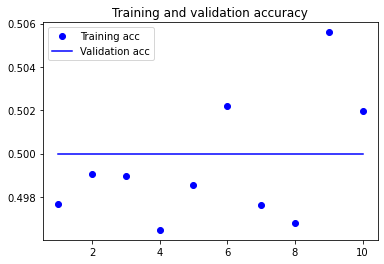

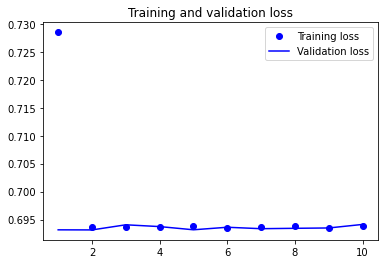

In [31]:
plot_result(history_6)

Chaning the learning rate did not help at all, as it made the model very unreliable and confusing.

### Removing layer and dropout again

The CNN does not have to learn a lot of features since the cell images are either a cell with dots inside or without dots inside. So the only features to really learn are these 'dots'. That is why I have decided to try a smaller model as the model_5.

In [32]:
# Removing one layer of droput aswell as one Conv2D and maxpooling layer, going with default learning rate again
model_7 = Sequential()
model_7.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_7.add(MaxPool2D(2,2))
model_7.add(Dropout(0.2))
model_7.add(Conv2D(64, (3,3), activation='relu'))
model_7.add(MaxPool2D(2,2))
model_7.add(Flatten())
model_7.add(Dense(1, activation='sigmoid'))

model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_7 = model_7.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=10,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/10
965/965 [==============================] - 243s 251ms/step - loss: 0.5225 - accuracy: 0.7597 - val_loss: 0.3605 - val_accuracy: 0.8864
Epoch 2/10
965/965 [==============================] - 242s 251ms/step - loss: 0.3732 - accuracy: 0.8691 - val_loss: 0.3661 - val_accuracy: 0.8612
Epoch 3/10
965/965 [==============================] - 243s 251ms/step - loss: 0.3477 - accuracy: 0.8745 - val_loss: 0.3654 - val_accuracy: 0.8578
Epoch 4/10
965/965 [==============================] - 242s 251ms/step - loss: 0.2982 - accuracy: 0.8998 - val_loss: 0.3403 - val_accuracy: 0.8685
Epoch 5/10
965/965 [==============================] - 241s 250ms/step - loss: 0.2559 - accuracy: 0.9157 - val_loss: 0.3655 - val_accuracy: 0.8627
Epoch 6/10
965/965 [==============================] - 243s 251ms/step - loss: 0.2017 - accuracy: 0.9344 - val_loss: 0.4258 - val_accuracy: 0.8200
Epoch 7/10
965/965 [==============================] - 241s 250ms/step - loss: 0.1643 - accuracy: 0.9493 - val_loss: 0.3142 -

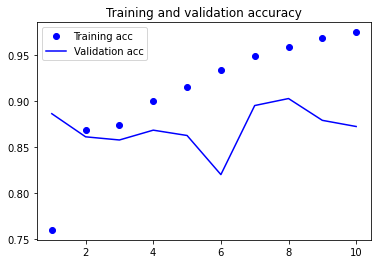

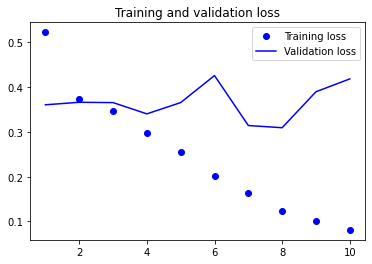

In [33]:
plot_result(history_7)

The plan of removing layers has not worked as validation accuarcy is now significantly lower than validation_accuarcy from model_5 with more layers.

I will add the layers back again and also add one more dense layer before the final dense layer.

### Adding layers again

In [34]:
# model_5 but with one more dense layer at the end after flattening
model_8 = Sequential()
model_8.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_8.add(MaxPool2D(2,2))
model_8.add(Dropout(0.2))
model_8.add(Conv2D(32, (3,3), activation='relu'))
model_8.add(MaxPool2D(2,2))
model_8.add(Dropout(0.3))
model_8.add(Conv2D(64, (3,3), activation='relu'))
model_8.add(MaxPool2D(2,2))
model_8.add(Flatten())
model_8.add(Dense(64, activation='relu'))
model_8.add(Dense(1, activation='sigmoid'))

model_8.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_8 = model_8.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=10,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/10
965/965 [==============================] - 260s 269ms/step - loss: 0.5363 - accuracy: 0.7103 - val_loss: 0.2117 - val_accuracy: 0.9254
Epoch 2/10
965/965 [==============================] - 258s 267ms/step - loss: 0.1920 - accuracy: 0.9328 - val_loss: 0.1756 - val_accuracy: 0.9467
Epoch 3/10
965/965 [==============================] - 257s 266ms/step - loss: 0.1601 - accuracy: 0.9446 - val_loss: 0.1494 - val_accuracy: 0.9523
Epoch 4/10
965/965 [==============================] - 256s 265ms/step - loss: 0.1474 - accuracy: 0.9511 - val_loss: 0.1547 - val_accuracy: 0.9517
Epoch 5/10
965/965 [==============================] - 257s 266ms/step - loss: 0.1381 - accuracy: 0.9530 - val_loss: 0.1471 - val_accuracy: 0.9536
Epoch 6/10
965/965 [==============================] - 256s 266ms/step - loss: 0.1263 - accuracy: 0.9557 - val_loss: 0.1392 - val_accuracy: 0.9525
Epoch 7/10
965/965 [==============================] - 256s 266ms/step - loss: 0.1125 - accuracy: 0.9607 - val_loss: 0.1422 -

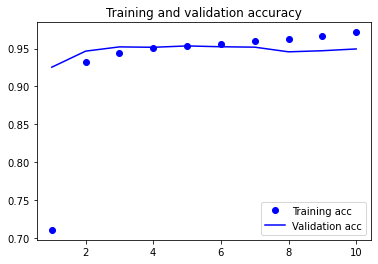

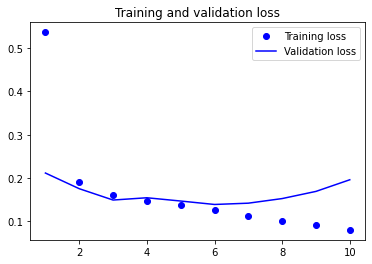

In [45]:
plot_result(history_8)

### Training for less epochs

In [35]:
# same as model_9 but trained for less epochs
model_9 = Sequential()
model_9.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_9.add(MaxPool2D(2,2))
model_9.add(Dropout(0.2))
model_9.add(Conv2D(32, (3,3), activation='relu'))
model_9.add(MaxPool2D(2,2))
model_9.add(Dropout(0.3))
model_9.add(Conv2D(64, (3,3), activation='relu'))
model_9.add(MaxPool2D(2,2))
model_9.add(Flatten())
model_9.add(Dense(64, activation='relu'))
model_9.add(Dense(1, activation='sigmoid'))

model_9.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_9 = model_9.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=5,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/5
965/965 [==============================] - 260s 268ms/step - loss: 0.4618 - accuracy: 0.7539 - val_loss: 0.2619 - val_accuracy: 0.8970
Epoch 2/5
965/965 [==============================] - 256s 265ms/step - loss: 0.1882 - accuracy: 0.9339 - val_loss: 0.1846 - val_accuracy: 0.9465
Epoch 3/5
965/965 [==============================] - 263s 272ms/step - loss: 0.1580 - accuracy: 0.9494 - val_loss: 0.1467 - val_accuracy: 0.9572
Epoch 4/5
965/965 [==============================] - 252s 261ms/step - loss: 0.1498 - accuracy: 0.9528 - val_loss: 0.1425 - val_accuracy: 0.9548
Epoch 5/5
965/965 [==============================] - 249s 258ms/step - loss: 0.1343 - accuracy: 0.9564 - val_loss: 0.1498 - val_accuracy: 0.9568


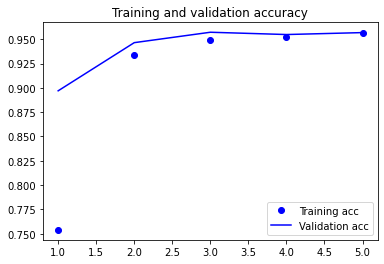

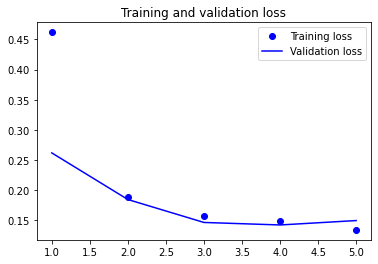

In [36]:
plot_result(history_9)

All models achieved validation accuarcy of ~ 95% after the second epoch of training which is why I decided to train the following models with 5 epochs instead of 10 as it does not change the result. Getting higher than 95% validation accuarcy looks to be impossible at this stage, as several options of hyperparameters have been exhausted but lets continue.

### Changing optimizer and learning rate:

In [38]:
# now trying rmsprop as optimizer
model_10 = Sequential()
model_10.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_10.add(MaxPool2D(2,2))
model_10.add(Dropout(0.2))
model_10.add(Conv2D(32, (3,3), activation='relu'))
model_10.add(MaxPool2D(2,2))
model_10.add(Dropout(0.3))
model_10.add(Conv2D(64, (3,3), activation='relu'))
model_10.add(MaxPool2D(2,2))
model_10.add(Flatten())
model_10.add(Dense(64, activation='relu'))
model_10.add(Dense(1, activation='sigmoid'))

model_10.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['accuracy'])

history_10 = model_10.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=5,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/5
965/965 [==============================] - 260s 269ms/step - loss: 0.4436 - accuracy: 0.7921 - val_loss: 0.2136 - val_accuracy: 0.9267
Epoch 2/5
965/965 [==============================] - 254s 264ms/step - loss: 0.2144 - accuracy: 0.9355 - val_loss: 0.2221 - val_accuracy: 0.9351
Epoch 3/5
965/965 [==============================] - 252s 261ms/step - loss: 0.1929 - accuracy: 0.9422 - val_loss: 0.1866 - val_accuracy: 0.9479
Epoch 4/5
965/965 [==============================] - 253s 262ms/step - loss: 0.1865 - accuracy: 0.9438 - val_loss: 0.1901 - val_accuracy: 0.9423
Epoch 5/5
965/965 [==============================] - 251s 260ms/step - loss: 0.1849 - accuracy: 0.9454 - val_loss: 0.1886 - val_accuracy: 0.9438


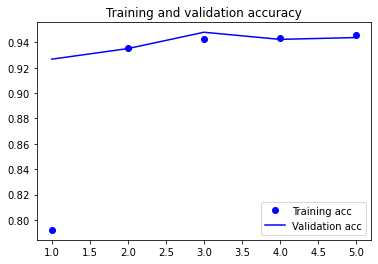

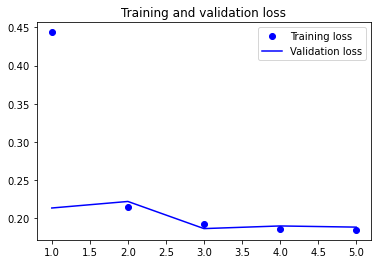

In [39]:
plot_result(history_10)

In [40]:
# trying RMSprop as optimizer but with learning rate of 0.002 instead of the default 0.001. otherwise same as previous model.
model_11 = Sequential()
model_11.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_11.add(MaxPool2D(2,2))
model_11.add(Dropout(0.2))
model_11.add(Conv2D(32, (3,3), activation='relu'))
model_11.add(MaxPool2D(2,2))
model_11.add(Dropout(0.3))
model_11.add(Conv2D(64, (3,3), activation='relu'))
model_11.add(MaxPool2D(2,2))
model_11.add(Flatten())
model_11.add(Dense(64, activation='relu'))
model_11.add(Dense(1, activation='sigmoid'))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.002)
model_11.compile(optimizer=opt, loss='binary_crossentropy', metrics = ['accuracy'])

history_11 = model_11.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=5,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/5
965/965 [==============================] - 258s 267ms/step - loss: 0.5040 - accuracy: 0.7680 - val_loss: 0.1929 - val_accuracy: 0.9445
Epoch 2/5
965/965 [==============================] - 253s 262ms/step - loss: 0.2105 - accuracy: 0.9372 - val_loss: 0.1980 - val_accuracy: 0.9476
Epoch 3/5
965/965 [==============================] - 253s 262ms/step - loss: 0.2026 - accuracy: 0.9404 - val_loss: 0.2070 - val_accuracy: 0.9321
Epoch 4/5
965/965 [==============================] - 252s 261ms/step - loss: 0.1941 - accuracy: 0.9407 - val_loss: 0.1875 - val_accuracy: 0.9401
Epoch 5/5
965/965 [==============================] - 251s 260ms/step - loss: 0.1866 - accuracy: 0.9440 - val_loss: 0.2396 - val_accuracy: 0.9367


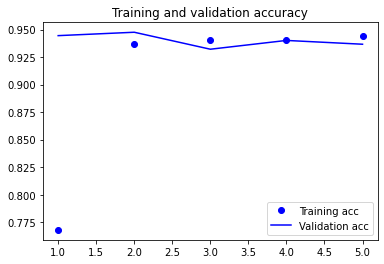

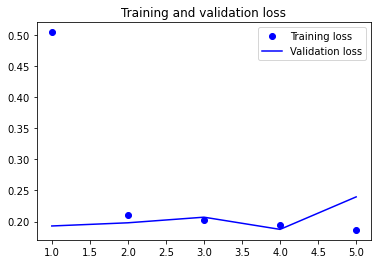

In [41]:
plot_result(history_11)

Changing the optimizer to rmsprop and the learning rate did not have any good outcome at all as validation accuarcy stayed below 95% and validatino loss did not lower.

### Advanced architecture

In [44]:
# trying advanced architecture patterns from DLWP
# Source: DLWP 7.3.1
model_12 = Sequential()
model_12.add(layers.SeparableConv2D(32, 3,activation='relu',input_shape=(150, 150, 3,)))
model_12.add(layers.SeparableConv2D(64, 3, activation='relu'))
model_12.add(layers.MaxPooling2D(2))
model_12.add(layers.SeparableConv2D(64, 3, activation='relu'))
model_12.add(layers.SeparableConv2D(128, 3, activation='relu'))
model_12.add(layers.MaxPooling2D(2))
model_12.add(layers.SeparableConv2D(64, 3, activation='relu'))
model_12.add(layers.SeparableConv2D(128, 3, activation='relu'))
model_12.add(layers.GlobalAveragePooling2D())
model_11.add(Flatten())
model_12.add(layers.Dense(32, activation='relu'))
model_12.add(Dense(1, activation='sigmoid'))

model_12.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_12 = model_12.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=5,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/5
965/965 [==============================] - 811s 840ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
965/965 [==============================] - 836s 866ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
965/965 [==============================] - 860s 891ms/step - loss: 0.6933 - accuracy: 0.4937 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
965/965 [==============================] - 811s 840ms/step - loss: 0.6932 - accuracy: 0.4924 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
965/965 [==============================] - 807s 836ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.5000


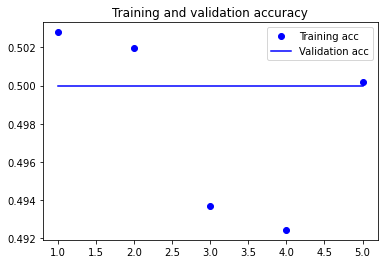

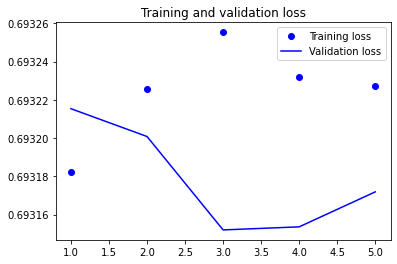

In [46]:
plot_result(history_12)

Now several options have been tried. One thing left to try is data augmentation which also prevents overfitting.

### Data Augmentation

In [47]:
# Using data augmentation to prevent overfitting
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

In [48]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 19290 images belonging to 2 classes.


In [49]:
# model_8 but this time the data will be augmented. Traing for 10 epochs again
model_13 = Sequential()
model_13.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_13.add(MaxPool2D(2,2))
model_13.add(Dropout(0.2))
model_13.add(Conv2D(32, (3,3), activation='relu'))
model_13.add(MaxPool2D(2,2))
model_13.add(Dropout(0.3))
model_13.add(Conv2D(64, (3,3), activation='relu'))
model_13.add(MaxPool2D(2,2))
model_13.add(Flatten())
model_13.add(Dense(64, activation='relu'))
model_13.add(Dense(1, activation='sigmoid'))

model_13.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_13 = model_13.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=10,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/10
965/965 [==============================] - 307s 317ms/step - loss: 0.5334 - accuracy: 0.7219 - val_loss: 0.2276 - val_accuracy: 0.9356
Epoch 2/10
965/965 [==============================] - 304s 315ms/step - loss: 0.2564 - accuracy: 0.9087 - val_loss: 0.1977 - val_accuracy: 0.9370
Epoch 3/10
965/965 [==============================] - 303s 314ms/step - loss: 0.2417 - accuracy: 0.9148 - val_loss: 0.1661 - val_accuracy: 0.9536
Epoch 4/10
965/965 [==============================] - 303s 314ms/step - loss: 0.2346 - accuracy: 0.9181 - val_loss: 0.1539 - val_accuracy: 0.9577
Epoch 5/10
965/965 [==============================] - 302s 313ms/step - loss: 0.2238 - accuracy: 0.9232 - val_loss: 0.5089 - val_accuracy: 0.9233
Epoch 6/10
965/965 [==============================] - 304s 315ms/step - loss: 0.2157 - accuracy: 0.9277 - val_loss: 0.1582 - val_accuracy: 0.9490
Epoch 7/10
965/965 [==============================] - 308s 319ms/step - loss: 0.2125 - accuracy: 0.9301 - val_loss: 0.1441 -

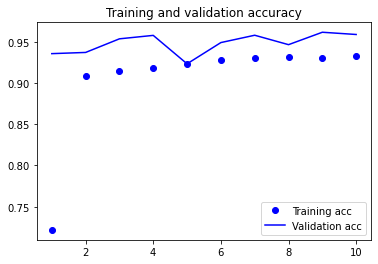

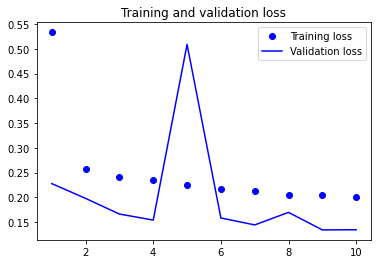

In [50]:
plot_result(history_13)

Augmenting the data did really have any impact. With almost 20k images there is also sufficent training data available so data augmentation is not that useful.

### Using the VGG16 

Below I will use the pretrained VGG16 model. Unfortunatly I can run tensorflow only on CPU which makes it unviable for me to run the second option which is suggested in DLWP. So the VGG16 can only be used to extract features without data augmentation.

In [52]:
# downloading VGG16 as convbase
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 11s 0us/step


In [53]:
# extracting features
#  Source for folling cells about VGG16: DLWP 5.17
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [54]:
train_features, train_labels = extract_features(train_dir, 19290 )

Found 19290 images belonging to 2 classes.


In [55]:
validation_features, validation_labels = extract_features(validation_dir, 5512  )

Found 5512 images belonging to 2 classes.


In [56]:
test_features, test_labels = extract_features(test_dir, 2756 )

Found 2756 images belonging to 2 classes.


In [57]:
# reshaping features
train_features = np.reshape(train_features, (19290, 4*4* 512))
validation_features = np.reshape(validation_features, (5512, 4*4* 512))
test_features = np.reshape(test_features, (2756 , 4*4* 512))

In [59]:
# classifier model which recieves features
model_14 = models.Sequential()
model_14.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model_14.add(layers.Dropout(0.5))
model_14.add(layers.Dense(1, activation='sigmoid'))
model_14.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])
history_14= model_14.fit(train_features, train_labels,
epochs=10,
batch_size=20,
validation_data=(validation_features, validation_labels))

C:\Users\mohrj\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
965/965 [==============================] - 20s 20ms/step - loss: 0.3882 - acc: 0.8270 - val_loss: 0.2711 - val_acc: 0.8899
Epoch 2/10
965/965 [==============================] - 19s 20ms/step - loss: 0.2606 - acc: 0.8983 - val_loss: 0.2280 - val_acc: 0.9057
Epoch 3/10
965/965 [==============================] - 19s 20ms/step - loss: 0.2281 - acc: 0.9136 - val_loss: 0.2064 - val_acc: 0.9122
Epoch 4/10
965/965 [==============================] - 19s 19ms/step - loss: 0.2090 - acc: 0.9214 - val_loss: 0.1904 - val_acc: 0.9234
Epoch 5/10
965/965 [==============================] - 18s 19ms/step - loss: 0.1949 - acc: 0.9276 - val_loss: 0.1831 - val_acc: 0.9269
Epoch 6/10
965/965 [==============================] - 18s 19ms/step - loss: 0.1871 - acc: 0.9305 - val_loss: 0.1821 - val_acc: 0.9256
Epoch 7/10
965/965 [==============================] - 18s 18ms/step - loss: 0.1807 - acc: 0.9318 - val_loss: 0.1729 - val_acc: 0.9321
Epoch 8/10
965/965 [==============================] - 18s 19ms

Unfortunatly this model couldn't get the same accuracy as the previous ones.

## Interpretation of the Results - Hyperparameter tuning

A lot has been tried, from adding dropout to chaning layers back and forth to chaning optimizers etc.

At last no model really stood out as most were around the 94% validation accuracy and 0.15 validation loss marks.

Changing the learning rate of the optimizer did not help either in achieving higher accuarcy. Data Augmentation was not that helpful either as there was sufficent training data available.

Even chaning to an advanced architecture for CNN's did not change the outcome. Validation accuracy stayed the same  or even got worse and stalled at around 50% for  some models.

## Training and evaluation of the final network on the whole dataset

For the final model I have gone  with the same architecture as model_8. 2 Conv2D layers with 2 maxpooling layers and dropout  inbetween. 2 Dense layers after flattening, one with relu activation the other of course with sigmoid.

The final model will be trained for 15 epochs on the usual training data. Then the optimal number of epochs will be found and then the final model will be trained on the whole training data. At last the model will be tested on the test data.

In [85]:
# this is my final model, lets train this model for 15 epochs and look for the optimal number of epochs
model_final = Sequential()
model_final.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_final.add(MaxPool2D(2,2))
model_final.add(Dropout(0.2))
model_final.add(MaxPool2D(2,2))
model_final.add(Dropout(0.3))
model_final.add(Conv2D(64, (3,3), activation='relu'))
model_final.add(MaxPool2D(2,2))
model_final.add(Flatten())
model_final.add(Dense(64, activation='relu'))
model_final.add(Dense(1, activation='sigmoid'))

model_final.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_final = model_final.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=15,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/15
965/965 [==============================] - 184s 190ms/step - loss: 0.4644 - accuracy: 0.7625 - val_loss: 0.2446 - val_accuracy: 0.9367
Epoch 2/15
965/965 [==============================] - 176s 183ms/step - loss: 0.2066 - accuracy: 0.9299 - val_loss: 0.1737 - val_accuracy: 0.9470
Epoch 3/15
965/965 [==============================] - 175s 182ms/step - loss: 0.1729 - accuracy: 0.9435 - val_loss: 0.1675 - val_accuracy: 0.9481
Epoch 4/15
965/965 [==============================] - 176s 183ms/step - loss: 0.1580 - accuracy: 0.9485 - val_loss: 0.1587 - val_accuracy: 0.9516
Epoch 5/15
965/965 [==============================] - 178s 184ms/step - loss: 0.1432 - accuracy: 0.9521 - val_loss: 0.1592 - val_accuracy: 0.9528
Epoch 6/15
965/965 [==============================] - 178s 184ms/step - loss: 0.1277 - accuracy: 0.9571 - val_loss: 0.1602 - val_accuracy: 0.9512
Epoch 7/15
965/965 [==============================] - 179s 186ms/step - loss: 0.1162 - accuracy: 0.9593 - val_loss: 0.1656 -

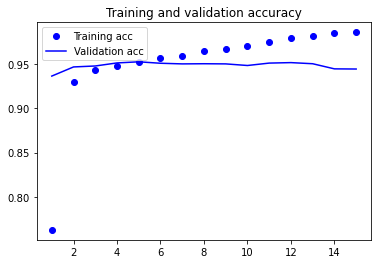

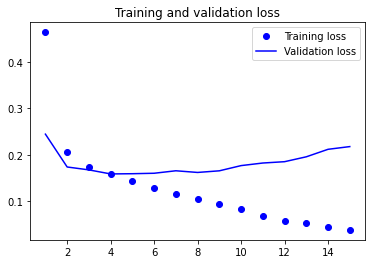

In [86]:
plot_result(history_final)


### Identifcation of optimal epochs for the final model

Overfitting starts after validation loss has hit its lowest point.
Which looks to be 3 epochs.

In [90]:
optimal_epoch = np.argmin(history_final.history['val_loss'])
print('Optimal number of epochs for this model: '+str(optimal_epoch))

Optimal number of epochs for this model: 3


### Training on whole training data

Because I split the whole data with splitfolders into 0.7/0.2/0.1 splits, I now have to copy the validation data back into the training folder, so I can use the ImageDataGenerator to generate batches on the whole training data.

In [91]:
# copying all files from validation directory into training directory again
source_folder = './cell_images/data/val/Parasitized/'
destination_folder = './cell_images/data/train/Parasitized/'
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    destination = destination_folder + file_name
    # copy only files
    if os.path.isfile(source):
        shutil.copy2(source, destination)

In [92]:
# copying all files from validation directory into training directory again
source_folder = './cell_images/data/val/Uninfected/'
destination_folder = './cell_images/data/train/Uninfected/'
# fetch all files
for file_name in os.listdir(source_folder):
    # construct full file path
    source = source_folder + file_name
    destination = destination_folder + file_name
    # copy only files
    if os.path.isfile(source):
        shutil.copy2(source, destination)

In [94]:
# instanciating new train_generator with full training data
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')

Found 24802 images belonging to 2 classes.


In [95]:
# final model being trained on the whole training set and on optimal number of epochs
model_final = Sequential()
model_final.add(Conv2D(16, (3,3), input_shape = (150, 150, 3), activation='relu'))
model_final.add(MaxPool2D(2,2))
model_final.add(Dropout(0.2))
model_final.add(MaxPool2D(2,2))
model_final.add(Dropout(0.3))
model_final.add(Conv2D(64, (3,3), activation='relu'))
model_final.add(MaxPool2D(2,2))
model_final.add(Flatten())
model_final.add(Dense(64, activation='relu'))
model_final.add(Dense(1, activation='sigmoid'))

model_final.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

history_final = model_final.fit(
x = train_generator,
steps_per_epoch=len(train_generator),
epochs=optimal_epoch,
validation_data=validation_generator,
validation_steps=len(validation_generator))

Epoch 1/3
1241/1241 [==============================] - 244s 196ms/step - loss: 0.4190 - accuracy: 0.7986 - val_loss: 0.1926 - val_accuracy: 0.9374
Epoch 2/3
1241/1241 [==============================] - 223s 180ms/step - loss: 0.2077 - accuracy: 0.9286 - val_loss: 0.2317 - val_accuracy: 0.9262
Epoch 3/3
1241/1241 [==============================] - 227s 183ms/step - loss: 0.1721 - accuracy: 0.9421 - val_loss: 0.1782 - val_accuracy: 0.9501


In [96]:
test_loss, test_acc = model_final.evaluate_generator(test_generator,steps=50)

C:\Users\mohrj\AppData\Local\Temp/ipykernel_7232/4232339360.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model_final.evaluate_generator(test_generator,steps=50)


In [97]:
print(test_loss,test_acc)

0.2144957333803177 0.9390000104904175


## Interpretation of the Results - Final Model

The model achieved an accuarcy of ~94% on the test set.

In the beginning I stated that scoring an accuarcy above 90% would be satisfying so the final_model beat that pretty handily.
The small baseline model in the beginning had ~79% accuracy so we improved a lot from that.

Achieving a accuarcy of ~ 94% is satisfying as all the other different models seemed to converge against 94% aswell.


# Results

At first  training the final model on only 3 epochs seemed low, but with the ImageDataGenerator the model is fed one iteration of the whole training data on one epoch, so essentially it has trained 3 times on the whole training set.

Since hyperparamter tuning was done thouroughly there are probably no other models in this size or scope that can achieve higher accuarcy than the one that was achieved by the final model. When looking at the pictures, there weren't really much features to extract for the CNN as the images consist of a round cell with either some dots in it, for infection, or no dots.
Because those images weren't say as complex as a image of a dog with facial features etc. the model was able to achieve high accuarcy.

Since only freshly built models were used to experiment on hyperparameters no infromation was leaked and the validation set was fine to use all the time.

The most suprising results of this investigation were that the advanced architecture did not achieve good accuracy aswell as the feature extraction from the VGG16 base. Also chaning the learning rate of the optimizers went horribly wrong each time.
But overall this was a successful invesigation as the goal of having an accuarcy above 90% has been achieved.


# Conclusion

This systematic investigation showed that a good CNN can be built from scratch to detect malaria infected cells.
It also showed that 95% accuracy was the upper limit for the scope of this investigation.

It is astonishing how much  AI and Neural Networks can contribute to the real world nowadays. Deceting malaria reliably, fast and at a huge scale like that is fascinating and immensly useful. This investigation showed that even a student can build a model which achievs 94% accuracy at detecting malaria infected cells. Because of applications like this, the fight against malaria and others diseases became easier. Deep learning will continue to have an positive impact like that as technology becomes even more advanced.


References: 

[1] https://www.who.int/news-room/fact-sheets/detail/malaria

[2] https://peerj.com/articles/6977/

[3] https://www.tensorflow.org/datasets/catalog/malaria